In [23]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib.request
import csv
import re
import pandas as pd
from pandas.plotting import scatter_matrix
import statsmodels.formula.api as sm
import scipy as sc
import matplotlib.pyplot as plt

In [36]:
# grab the robot.txt and save to the working directory for reference
with urlopen("https://news.ycombinator.com/robots.txt") as stream:
    print(stream.read().decode("utf-8"))

User-Agent: * 
Disallow: /x?
Disallow: /vote?
Disallow: /reply?
Disallow: /submitted?
Disallow: /submitlink?
Disallow: /threads?
Crawl-delay: 30



# Part 1: Grab the first 5 pages of stories from hackernews. 
### For each story, grab the following data:

    Rank (the number of the story on hacker news)
    Length of the title
    Age, in hours (note, some stories are days or minutes old. You should be able to handle this)
    Points (note, some stories don't have scores! Give them 0 points)
    Number of comments (again, some stories have no comments. Mark them 0)


In [12]:
for i in range(1, 6):
    pageUrl = "https://news.ycombinator.com/news?p=" + str(i)
    with urllib.request.urlopen(pageUrl) as response:
        html = response.read()
        html = html.decode('utf-8')
    file = "page" + str(i) + ".html"
    with open(file, 'w') as new_file:
        new_file.write(html)

In [13]:
rank = []
titleLen = []
age = []
points = []
commentNum = []
for i in range(1, 6):
    file = "page" + str(i) + ".html"
    soup = BeautifulSoup(open(file), "html.parser")
    for r in soup.find_all(class_="rank"):
        rank.append(int(r.get_text().replace(".", "")))
    for t in soup.find_all(class_="storylink"):
        titleLen.append(len(t.get_text()))
    for a in soup.find_all(class_="age"):
        text = a.find("a").get_text().split(" ")
        if(text[1] == "minutes"):
            age.append(int(text[0]) / 60)
        elif(text[1] == "hours"):
            age.append(int(text[0]))
        elif(text[1] == "day"):
            age.append(int(text[0]) * 24)
        else:
            age.append(0)
    for s in soup.find_all(class_="subtext"):
        if "score" in str(s):
            points.append(int(s.find(class_="score").get_text().split(" ")[0]))
        else:
            points.append(0)
        if "comments" in str(s):
            commentNum.append(int(s.find_all("a")[3].get_text().replace("\xa0", " ").split(" ")[0]))
        else:
            commentNum.append(0)
        
        
        
print('rank: ' + str(len(rank)))
print('length: ' + str(len(titleLen)))
print('age: ' + str(len(age)))
print('points: ' + str(len(points)))
print('commentNum: ' + str(len(commentNum)))
        
        

rank: 150
length: 150
age: 150
points: 150
commentNum: 150


In [37]:
data = pd.DataFrame({"Rank" : rank, "Title_Length" : titleLen, "Age" : age, "Points" : points, "Comment_Num" : commentNum})
data.to_csv('Top_Stories.csv', encoding='utf-8')

In [15]:
# offline webscrape from csv data
df = pd.read_csv("Top_Stories.csv", index_col=0)
df

,Rank,Title_Length,Age,Points,Comment_Num
0,1,44,0.0,76,26
1,2,78,4.0,179,78
2,3,61,2.0,179,56
3,4,26,0.0,55,15
4,5,75,0.0,25,0
5,6,76,5.0,101,20
6,7,42,0.1,4,0
7,8,58,7.0,152,16
8,9,34,4.0,56,4
9,10,61,0.0,33,19


# Part 2: Regression

We're interested in how to get a high-ranking story on Hackernews. Explore several possible linear regressions to 
predict a story's rank based on the other variables (or combinations thereof). Include at least 3 different 
regressions. Compare/contrast them. Which is the most useful. Are there linear relationships between any of the 
variables?

In [16]:
# Regression 1: 
reg1 =  sm.ols(formula="Rank ~ Title_Length + Age + Points + Comment_Num", data=df).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     10.35
Date:                Fri, 31 May 2019   Prob (F-statistic):           2.12e-07
Time:                        09:42:12   Log-Likelihood:                -759.23
No. Observations:                 150   AIC:                             1528.
Df Residuals:                     145   BIC:                             1544.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.3950     11.761      4.370      0.000      28.150      74.640
Title_Length    -0.0770      0.183     -0.422      0.674      -0.438       0.284
Age              2.2543      0.367      6.136      0.000       1.528       2.980
Points          -0.0427      0.023     -1.857      0.065      -0.088       0.003
Comment_Num      0.0900      0.066      1.355      0.178      -0.041       0.221
==============================================================================
Omnibus:                       13.046   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.429
Skew:                           0.759   Prob(JB):                     0.000736
Kurtosis:                       3.054   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Findings for Regression 1:
When looking at all of variables together, there is not a strong R-squared value to show a strong correlation amongst all variables and the ranking.  It is also worth nothing that several of the coefficients are negative and therefore the length of the title and the number of points likely have no relationship between the other variables.

In [17]:
# Regression 2: 
# Null hypothesis: the rank of a Hackernews story is based on length of the title.
reg2 =  sm.ols(formula="Rank ~ Age + Comment_Num", data=df).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     18.78
Date:                Fri, 31 May 2019   Prob (F-statistic):           5.44e-08
Time:                        09:42:12   Log-Likelihood:                -761.00
No. Observations:                 150   AIC:                             1528.
Df Residuals:                     147   BIC:                             1537.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      48.0964      5.700      8.438      0.000      36.831      59.361
Age             2.2046      0.360      6.128      0.000       1.494       2.916
Comment_Num    -0.0229      0.027     -0.849      0.397      -0.076       0.030
==============================================================================
Omnibus:                       12.149   Durbin-Watson:                   0.367
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.369
Skew:                           0.731   Prob(JB):                      0.00125
Kurtosis:                       2.990   Cond. No.                         241.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Findings for Regression 2:
We've removed the other negative variables, from the first regression, and raised both the f-statistic and coef for age.  While doing this, we've also received a negative result for the number of comments.  Because the increase in the first variable and decrease in the second, there is likely no relationship between the two affecting ranking.

In [18]:
# Regression 3: 
# Null hypothesis: the rank of a Hackernews story is based on the number of points it has.
reg3 =  sm.ols(formula="Rank ~ Age", data=df).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     36.92
Date:                Fri, 31 May 2019   Prob (F-statistic):           9.96e-09
Time:                        09:42:12   Log-Likelihood:                -761.36
No. Observations:                 150   AIC:                             1527.
Df Residuals:                     148   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.3349      5.624      8.417      0.000      36.222      58.448
Age            2.1553      0.355      6.076      0.000       1.454       2.856
==============================================================================
Omnibus:                        9.927   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.719
Skew:                           0.651   Prob(JB):                      0.00470
Kurtosis:                       2.864   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Findings for Regression 3:
While we've dwindled the regression down to rank and age, there is likely no correlation given no p-value, so we reject the null hypothesis at 5% and 1%.  The probability of the f value is significantly smaller than the f-statistic, which also fuels our rejection of the null hypothesis.

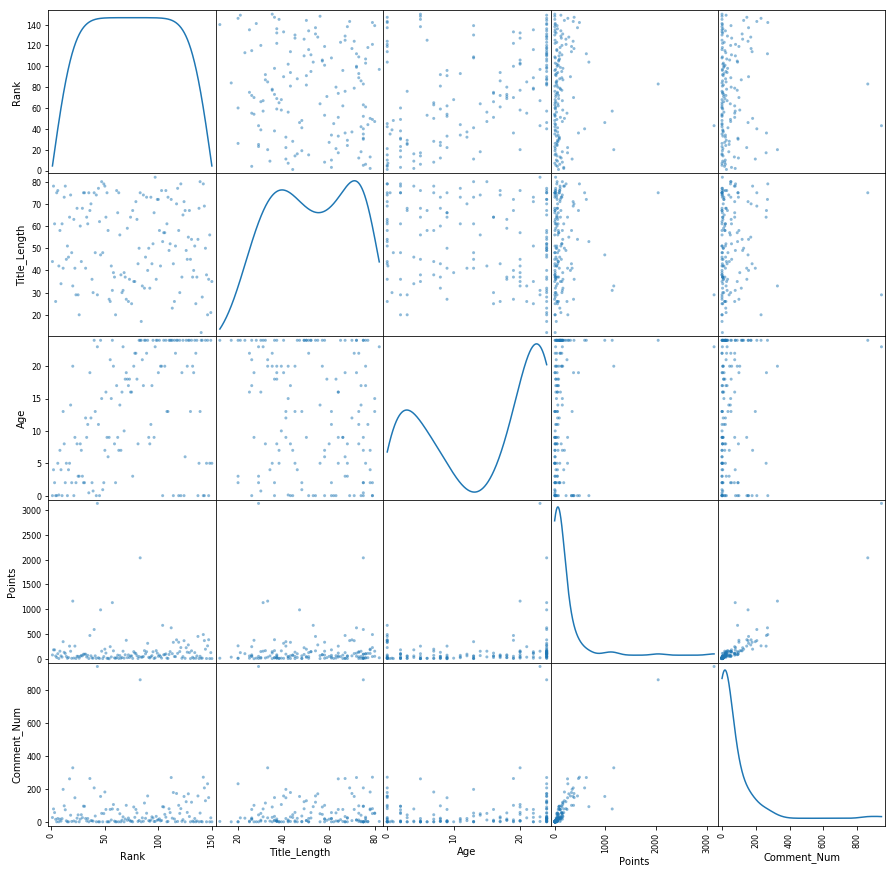

In [19]:
# Multilinear Regression
ax=scatter_matrix(df, figsize=(15,15), diagonal='kde')
plt.show()

# MLR Findings
As noted with the regression results above this plot, there does not seem to be a strong relationship between the four variables.  It should also be noted that the highest r-squared value is between rank and all other 4 variables.  

Points and comments have a positive correlation, but this is not relevant to our search for a correlation between ranking and other variables.  

# Part 3 Classification

As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic 
regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) 
variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for 
not), for example.

Include plots showing your regression (for the functions of 1 or 2 variables). What do your regressions tell you 
about making the front page?

In [20]:
# convert the first page Rank to indicator variable (1); 30 is first page length
df['Rank'] = (df['Rank'] <= 30).astype(int)
df


,Rank,Title_Length,Age,Points,Comment_Num
0,1,44,0.0,76,26
1,1,78,4.0,179,78
2,1,61,2.0,179,56
3,1,26,0.0,55,15
4,1,75,0.0,25,0
5,1,76,5.0,101,20
6,1,42,0.1,4,0
7,1,58,7.0,152,16
8,1,34,4.0,56,4
9,1,61,0.0,33,19


Optimization terminated successfully.
         Current function value: 0.377994
         Iterations 7


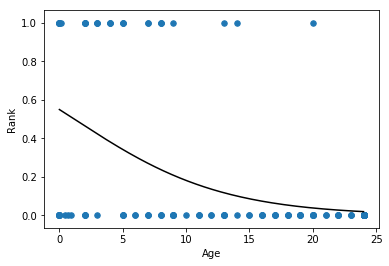

In [24]:
fpModel = sm.logit(formula="Rank ~ Age", data=df).fit()
fpModel.summary()
df.plot.scatter(x='Age', y='Rank', s=30)
x = sc.linspace(df['Age'].min(), df['Age'].max(), 150)
par = dict(fpModel.params)
logistic = lambda x: 1/(1 + sc.exp(-x))
plt.plot(x, logistic(par['Intercept'] + par['Age'] * x), color = 'Black')
plt.show()

In [26]:
fpModel.predict(pd.DataFrame({'Age': [2]}))

0    0.464578
dtype: float64

In [27]:
df['predFP'] = fpModel.predict() > 0.5
pd.crosstab(index=df['Rank'], columns=df['predFP'])

predFP,False,True
Rank,,
0,106,14
1,23,7


In [28]:
fpModel = sm.logit(formula="Rank ~ Points", data=df).fit()
fpModel.summary()

Optimization terminated successfully.
         Current function value: 0.498763
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 May 2019   Pseudo R-squ.:                0.003275
Time:                        09:47:55   Log-Likelihood:                -74.815
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                    0.4832
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3121      0.231     -5.678      0.000      -1.765      -0.859
Points        -0.0005      0.001     -0.619      0.536      -0.002       0.001
==============================================================================
"""

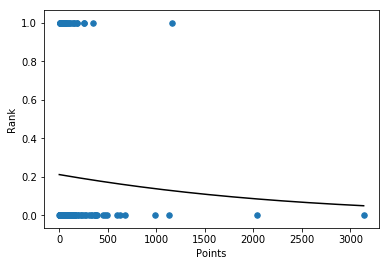

In [29]:
df.plot.scatter(x='Points', y='Rank', s=30)
x = sc.linspace(df['Points'].min(), df['Points'].max(), 150)
par = dict(fpModel.params)
logistic = lambda x: 1/(1 + sc.exp(-x))
plt.plot(x, logistic(par['Intercept'] + par['Points'] * x), color = 'Black')
plt.show()

In [30]:
df['predFP'] = fpModel.predict() > 0.5
pd.crosstab(index=df['Rank'], columns=df['predFP'])

predFP,False
Rank,
0,120
1,30


In [31]:
fpModel = sm.logit(formula="Rank ~ Points + Age", data=df).fit()
fpModel.summary()

Optimization terminated successfully.
         Current function value: 0.377769
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Rank   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Fri, 31 May 2019   Pseudo R-squ.:                  0.2451
Time:                        09:49:11   Log-Likelihood:                -56.665
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                 1.026e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1719      0.334      0.514      0.607      -0.483       0.827
Points         0.0003      0.001      0.275      0.783      -0.002       0.002
Age           -0.1710      0.035     -4.824      0.000      -0.240      -0.102
==============================================================================
"""

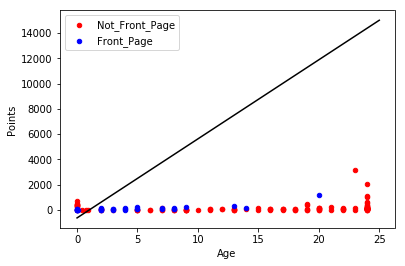

In [35]:
ax = df[df['Rank']==0].plot.scatter(x='Age',y='Points',color='red',label='Not_Front_Page')
df[df['Rank']==1].plot.scatter(x='Age',y='Points',color='blue',label='Front_Page', ax=ax)

x = sc.linspace(0,25,50)
par = dict(fpModel.params)
p = sc.linspace(1e-5,1-1e-5,1000)
odds = lambda p: p/(1-p)
logit = lambda p: sc.log(odds(p))
plt.plot(x,(1/par['Points'])*(logit(.5) - par['Intercept'] - par['Age']*x),color='Black')

plt.xlabel('Age')
plt.ylabel('Points')
plt.legend(loc='upper left')
plt.show()

# Conclusion:
The lower the age, the higher the chance that the story will appear on the HN front page in comparison to the number of points the story has.  This confirms the weak, positive relationship found during the second part.